In [105]:
import pandas as pd

In [106]:
pred_PLS_SM = pd.read_csv("./data/data/PLS_SM/tar_pred.csv")
pred_PLS_SM.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

pred_ICA = pd.read_csv("./data/data/jade/ica/tar_pred.csv")
pred_ICA["Sample Name"] = pred_ICA["target"]
pred_ICA.drop(columns=["target"], axis=1, inplace=True)

In [107]:
pred_ICA.columns

Index(['ID', 'SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O',
       'Sample Name'],
      dtype='object')

In [108]:
pred_ICA.head()

,ID,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name
0,jsc1399_2013_09_11_151245_ccs,54.358193,0.915070,20.829506,13.384058,6.189111,8.389946,4.604968,1.085528,jsc1399
1,r65_2013_11_05_151321_ccs,58.864656,0.057594,12.543319,4.811779,6.537739,5.210740,2.962094,2.150490,r65
2,vzo106_2013_09_03_181628_ccs,66.275026,0.698434,12.804766,8.597515,-0.085340,1.824899,2.953498,1.731704,vzo106
3,201424_2013_11_06_155255_ccs,64.125299,0.886038,14.750741,4.977112,4.747535,2.304864,2.753124,2.874335,201424
4,jsc1424_2013_09_16_145015_ccs,57.353441,1.176242,13.347413,12.256024,3.557050,5.910352,1.648106,0.378352,jsc1424


In [109]:
ids_to_keep = pred_ICA["ID"]
filtered_pred_PLS_SM = pred_PLS_SM[pred_PLS_SM['ID'].isin(ids_to_keep)]

In [110]:
filtered_pred_PLS_SM.set_index("ID", inplace=True)
pred_ICA.set_index("ID", inplace=True)

In [111]:
aligned_pred_PLS_SM, aligned_pred_ICA = filtered_pred_PLS_SM.align(pred_ICA, join="inner", axis=0)

In [112]:
aligned_pred_PLS_SM

,Sample Name,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O
ID,,,,,,,,,
jsc1426_2013_09_16_151528_ccs,jsc1426,43.272102,0.612356,8.318778,18.612178,-1.592595,0.847359,0.629171,4.729945
bk2_2013_08_06_184259_ccs,bk2,57.022310,0.783517,15.710490,6.360495,2.768913,3.445408,3.983170,3.635040
jsc1379_2013_09_10_142041_ccs,jsc1379,53.631809,0.716445,18.664286,8.947575,3.930170,3.189598,3.805468,1.787900
gbw07108_2013_08_07_145651_ccs,gbw07108,45.108872,0.558653,10.714160,6.346359,4.427723,6.873007,0.730689,2.091162
jsc1456_2013_09_18_160559_ccs,jsc1456,49.244471,2.141077,18.075232,10.248474,5.123203,5.537359,4.458741,2.018456
...,...,...,...,...,...,...,...,...,...
gbw07105_2013_08_07_142727_ccs,gbw07105,50.658434,1.490208,14.444265,11.102855,7.709017,4.408383,3.743653,2.186646
sarm51_2013_08_29_145612_ccs,sarm51,49.346731,0.798746,9.491676,13.755718,1.444647,2.155893,0.620815,1.879698
s4_2013_11_05_155948_ccs,s4,60.013166,0.986368,19.414101,7.152314,1.322418,0.495989,0.652326,3.853172


In [113]:
from lib.reproduction import weighted_sum_oxide_percentages, major_oxides

merged_df = pd.merge(aligned_pred_ICA, aligned_pred_PLS_SM, on='Sample Name', suffixes=('_ICA', '_PLS_SM'))
moc_predictions = pd.DataFrame()

for oxide in major_oxides:
    w_ica = weighted_sum_oxide_percentages[oxide]['ICA'] / 100
    w_pls_sm = weighted_sum_oxide_percentages[oxide]['PLS1-SM'] / 100
    moc_predictions[oxide] = merged_df[oxide + '_ICA'] * w_ica + merged_df[oxide + '_PLS_SM'] * w_pls_sm

moc_predictions['Sample Name'] = merged_df['Sample Name']
moc_predictions['ID'] = aligned_pred_ICA.index

In [114]:
moc_predictions

,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name,ID
0,51.352427,0.003484,8.518945,17.922048,-1.583035,2.480535,2.636610,2.496030,jsc1426,jsc1426_2013_09_16_151528_ccs
1,59.897344,1.438582,18.093307,6.121018,3.002649,3.702440,5.876063,5.346857,bk2,bk2_2013_08_06_184259_ccs
2,54.193382,0.885167,18.732724,9.260134,4.636438,4.982487,4.640171,1.001360,jsc1379,jsc1379_2013_09_10_142041_ccs
3,31.611049,0.202631,9.985276,6.414847,7.003066,17.564960,2.375876,0.390302,gbw07108,gbw07108_2013_08_07_145651_ccs
4,48.871739,2.175100,19.152694,10.400062,5.358990,5.332684,3.151935,1.434118,jsc1456,jsc1456_2013_09_18_160559_ccs
...,...,...,...,...,...,...,...,...,...,...
66,45.615280,1.782714,15.918423,11.697593,8.690470,5.902126,3.675278,1.307176,gbw07105,gbw07105_2013_08_07_142727_ccs
67,52.417635,0.384429,10.176269,12.884808,-3.544885,5.679295,3.219882,0.336560,sarm51,sarm51_2013_08_29_145612_ccs
68,61.767668,1.185721,18.865671,7.507567,2.946943,0.178856,1.704122,3.753766,s4,s4_2013_11_05_155948_ccs
69,77.012413,0.307346,14.110575,5.381059,0.302093,-0.091222,1.458344,3.706397,gl7mt,gl7mt_2013_10_23_144551_ccs


In [115]:
from lib.data_handling import CompositionData

cd = CompositionData("data/data/calib/ccam_calibration_compositions.csv")

In [116]:
def merge_with_actual_data(moc_predictions):
    merged_data = pd.DataFrame()

    for index, row in moc_predictions.iterrows():
        actual_data = cd.get_composition_for_sample(row['Sample Name'])

        if not actual_data.empty:
            for oxide in major_oxides:
                merged_data.at[index, oxide + '_pred'] = row[oxide]
                merged_data.at[index, oxide + '_actual'] = actual_data[oxide].values[0]
            merged_data.at[index, 'Sample Name'] = row['Sample Name']

    return merged_data

In [117]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(merged_data):
    rmse_values = {}
    for oxide in major_oxides:
        y_actual = merged_data[oxide + '_actual']
        y_pred = merged_data[oxide + '_pred']
        rmse = mean_squared_error(y_actual, y_pred, squared=False)
        rmse_values[oxide] = rmse
    return rmse_values

# Usage example
merged_moc_actual_df = merge_with_actual_data(moc_predictions)
moc_rmse_values = calculate_rmse(merged_moc_actual_df)

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

In [118]:
SiO2_eval_df = pd.merge(merged_df[["SiO2_ICA", "SiO2_PLS_SM", "Sample Name"]], 
                    merged_moc_actual_df[["SiO2_actual", "SiO2_pred", "Sample Name"]], 
                    on="Sample Name")

SiO2_eval_df = SiO2_eval_df[0:5]
SiO2_eval_df

,SiO2_ICA,SiO2_PLS_SM,Sample Name,SiO2_actual,SiO2_pred
0,59.432752,43.272102,jsc1426,19.3,51.352427
1,62.772379,57.022310,bk2,58.83,59.897344
2,54.754955,53.631809,jsc1379,48.93,54.193382
3,18.113227,45.108872,gbw07108,15.6,31.611049
4,48.499007,49.244471,jsc1456,49.31,48.871739


/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gro

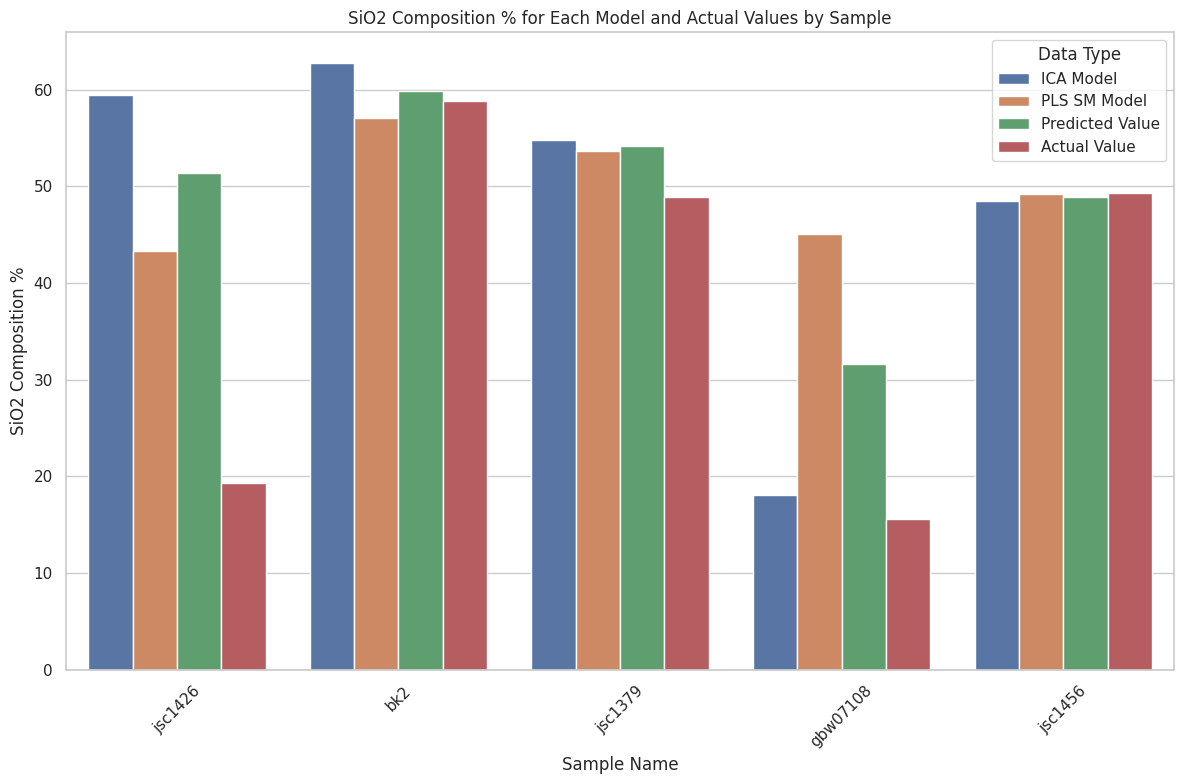

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plot
sns.set(style="whitegrid")

# Creating a figure for the plot
plt.figure(figsize=(12, 8))

# Creating aliases for the value_vars
aliases = {
    'SiO2_ICA': 'ICA Model',
    'SiO2_PLS_SM': 'PLS SM Model',
    'SiO2_pred': 'Predicted Value',
    'SiO2_actual': 'Actual Value'
}

# Merging the data for actual and predicted values for the plot
melted_data = pd.melt(SiO2_eval_df, id_vars='Sample Name', value_vars=list(aliases.keys()))

# Renaming the columns based on aliases
melted_data = melted_data.rename(columns={'variable': 'Model/Value', 'value': 'SiO2 Composition %'})
melted_data['Model/Value'] = melted_data['Model/Value'].map(aliases)

# Creating the grouped bar chart
sns.barplot(x='Sample Name', y='SiO2 Composition %', hue='Model/Value', data=melted_data)

# Adding labels and title
plt.xlabel('Sample Name')
plt.ylabel('SiO2 Composition %')
plt.title('SiO2 Composition % for Each Model and Actual Values by Sample')
plt.xticks(rotation=45)
plt.legend(title='Data Type')

plt.gca().invert_yaxis()

# Displaying the plot
plt.tight_layout()
plt.show()

In [120]:
merged_moc_actual_df

,SiO2_pred,SiO2_actual,TiO2_pred,TiO2_actual,Al2O3_pred,Al2O3_actual,FeOT_pred,FeOT_actual,MgO_pred,MgO_actual,CaO_pred,CaO_actual,Na2O_pred,Na2O_actual,K2O_pred,K2O_actual,Sample Name
0,51.352427,19.3,0.003484,0.08,8.518945,1.49,17.922048,65.85,-1.583035,0.77,2.480535,0.77,2.636610,0.45,2.496030,0.16,jsc1426
1,59.897344,58.83,1.438582,1.94,18.093307,14.77,6.121018,7.90,3.002649,2.82,3.702440,4.64,5.876063,3.35,5.346857,3.99,bk2
2,54.193382,48.93,0.885167,0.57,18.732724,22.66,9.260134,7.67,4.636438,4.34,4.982487,9.80,4.640171,3.13,1.001360,0.45,jsc1379
3,31.611049,15.6,0.202631,0.33,9.985276,5.03,6.414847,2.27,7.003066,5.19,17.564960,35.67,2.375876,0.08,0.390302,0.78,gbw07108
4,48.871739,49.31,2.175100,2.72,19.152694,16.46,10.400062,10.93,5.358990,3.93,5.332684,6.75,3.151935,4.58,1.434118,1.82,jsc1456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,45.615280,44.64,1.782714,2.37,15.918423,13.83,11.697593,12.06,8.690470,7.77,5.902126,8.81,3.675278,3.38,1.307176,2.32,gbw07105
67,52.417635,33.81,0.384429,0.82,10.176269,11.87,12.884808,16.52,-3.544885,0.92,5.679295,0.86,3.219882,0.07,0.336560,0.33,sarm51
68,61.767668,67.4,1.185721,0.9,18.865671,16.30,7.507567,5.14,2.946943,1.81,0.178856,0.21,1.704122,0.81,3.753766,3.4,s4
69,77.012413,77.54,0.307346,0.33,14.110575,11.17,5.381059,2.54,0.302093,1.08,-0.091222,0.07,1.458344,2.33,3.706397,2.39,gl7mt


In [121]:
moc_rmse_values

{'SiO2': 8.937993193000052,
 'TiO2': 0.5116865257270814,
 'Al2O3': 3.016863503624519,
 'FeOT': 7.660371505058508,
 'MgO': 1.663675227082065,
 'CaO': 4.884087108960508,
 'Na2O': 1.1040491176522444,
 'K2O': 1.1558000622738693}

In [122]:
ICA_actual_merged_df = merge_with_actual_data(aligned_pred_ICA)
ICA_rmses = calculate_rmse(ICA_actual_merged_df)

PLS_SM_actual_merged_df = merge_with_actual_data(aligned_pred_PLS_SM)
PLS_SM_rmses = calculate_rmse(PLS_SM_actual_merged_df)

ICA_rmses

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

{'SiO2': 10.733351503419852,
 'TiO2': 0.630111277136453,
 'Al2O3': 5.548546427605581,
 'FeOT': 8.299246038856959,
 'MgO': 2.9022778097822357,
 'CaO': 3.521759082875863,
 'Na2O': 1.720635345835822,
 'K2O': 1.367247198773664}

In [123]:
PLS_SM_actual_merged_df

,SiO2_pred,SiO2_actual,TiO2_pred,TiO2_actual,Al2O3_pred,Al2O3_actual,FeOT_pred,FeOT_actual,MgO_pred,MgO_actual,CaO_pred,CaO_actual,Na2O_pred,Na2O_actual,K2O_pred,K2O_actual,Sample Name
jsc1426_2013_09_16_151528_ccs,43.272102,19.3,0.612356,0.08,8.318778,1.49,18.612178,65.85,-1.592595,0.77,0.847359,0.77,0.629171,0.45,4.729945,0.16,jsc1426
bk2_2013_08_06_184259_ccs,57.022310,58.83,0.783517,1.94,15.710490,14.77,6.360495,7.90,2.768913,2.82,3.445408,4.64,3.983170,3.35,3.635040,3.99,bk2
jsc1379_2013_09_10_142041_ccs,53.631809,48.93,0.716445,0.57,18.664286,22.66,8.947575,7.67,3.930170,4.34,3.189598,9.80,3.805468,3.13,1.787900,0.45,jsc1379
gbw07108_2013_08_07_145651_ccs,45.108872,15.6,0.558653,0.33,10.714160,5.03,6.346359,2.27,4.427723,5.19,6.873007,35.67,0.730689,0.08,2.091162,0.78,gbw07108
jsc1456_2013_09_18_160559_ccs,49.244471,49.31,2.141077,2.72,18.075232,16.46,10.248474,10.93,5.123203,3.93,5.537359,6.75,4.458741,4.58,2.018456,1.82,jsc1456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gbw07105_2013_08_07_142727_ccs,50.658434,44.64,1.490208,2.37,14.444265,13.83,11.102855,12.06,7.709017,7.77,4.408383,8.81,3.743653,3.38,2.186646,2.32,gbw07105
sarm51_2013_08_29_145612_ccs,49.346731,33.81,0.798746,0.82,9.491676,11.87,13.755718,16.52,1.444647,0.92,2.155893,0.86,0.620815,0.07,1.879698,0.33,sarm51
s4_2013_11_05_155948_ccs,60.013166,67.4,0.986368,0.9,19.414101,16.30,7.152314,5.14,1.322418,1.81,0.495989,0.21,0.652326,0.81,3.853172,3.4,s4
gl7mt_2013_10_23_144551_ccs,78.102580,77.54,0.647306,0.33,12.498653,11.17,6.499695,2.54,0.194543,1.08,-0.392676,0.07,2.221226,2.33,2.149727,2.39,gl7mt


In [124]:
PLS_SM_rmses

{'SiO2': 9.548282852969782,
 'TiO2': 0.49896074968658594,
 'Al2O3': 2.834134078287734,
 'FeOT': 7.58293504026471,
 'MgO': 1.7193602801158816,
 'CaO': 7.23696426785395,
 'Na2O': 0.6645172712995686,
 'K2O': 1.1736211811900958}

In [125]:
RMSEs_df = pd.DataFrame([ICA_rmses, PLS_SM_rmses, moc_rmse_values], index=["ICA", "PLS_SM", "MOC (ours)"])

In [126]:
RMSEs_df.T

,ICA,PLS_SM,MOC (ours)
SiO2,10.733352,9.548283,8.937993
TiO2,0.630111,0.498961,0.511687
Al2O3,5.548546,2.834134,3.016864
FeOT,8.299246,7.582935,7.660372
MgO,2.902278,1.719360,1.663675
CaO,3.521759,7.236964,4.884087
Na2O,1.720635,0.664517,1.104049
K2O,1.367247,1.173621,1.155800


In [127]:
MOC_model_rmses = {
    'SiO2': 5.83,
    'TiO2': 1.10,
    'Al2O3': 3.18,
    'FeOT': 2.90,
    'MgO': 2.30,
    'CaO': 1.14,
    'Na2O': 1.34,
    'K2O': 1.49
 }

In [128]:
R_df = RMSEs_df.T
R_df['MOC (actual)'] = MOC_model_rmses.values()

In [129]:
R_df
# R_df.to_csv("eval.csv")

,ICA,PLS_SM,MOC (ours),MOC (actual)
SiO2,10.733352,9.548283,8.937993,5.83
TiO2,0.630111,0.498961,0.511687,1.10
Al2O3,5.548546,2.834134,3.016864,3.18
FeOT,8.299246,7.582935,7.660372,2.90
MgO,2.902278,1.719360,1.663675,2.30
CaO,3.521759,7.236964,4.884087,1.14
Na2O,1.720635,0.664517,1.104049,1.34
K2O,1.367247,1.173621,1.155800,1.49


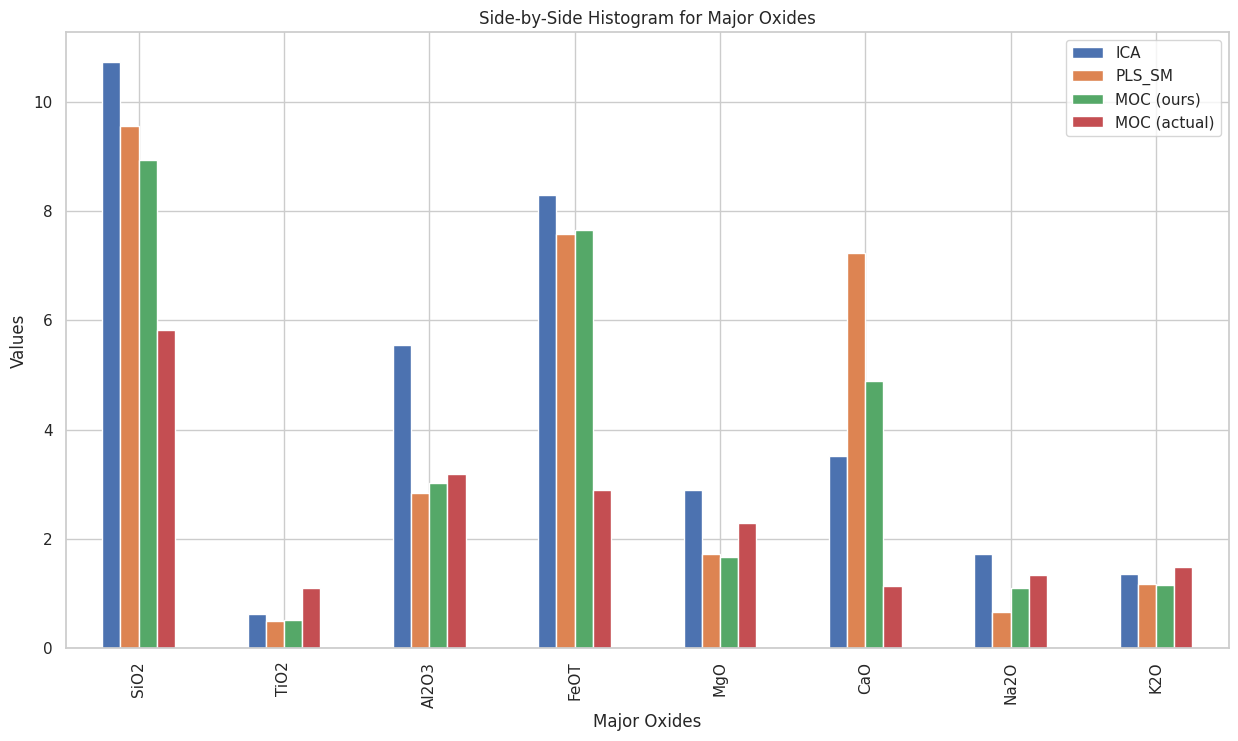

In [130]:
import matplotlib.pyplot as plt

# Setting the first column as the index
# R_df.set_index('Unnamed: 0', inplace=True)

# Creating the plot
ax = R_df.plot(kind='bar', figsize=(15, 8))

# Adding labels and title
ax.set_ylabel('Values')
ax.set_xlabel('Major Oxides')
ax.set_title('Side-by-Side Histogram for Major Oxides')

# Display the plot
plt.show()
